# The Devito domain specific language: an overview

This notebook presents an overview of the Devito symbolic language, used to express and discretise operators, in particular partial differential equations (PDEs).

For convenience, we import all Devito modules:

In [1]:
from devito import *

## From equations to code in a few lines of Python

The main objective of this tutorial is to demonstrate how Devito and its [SymPy](http://www.sympy.org/en/index.html)-powered symbolic API can be used to solve partial differential equations using the finite difference method with highly optimized stencils in a few lines of Python. We demonstrate how computational stencils can be derived directly from the equation in an automated fashion and how Devito can be used to generate and execute, at runtime, the desired numerical scheme in the form of optimized C code.


## Defining the physical domain

Before we can begin creating finite-difference (FD) stencils we will need to give Devito a few details regarding the computational domain within which we wish to solve our problem. For this purpose we create a `Grid` object that stores the physical `extent` (the size) of our domain and knows how many points we want to use in each dimension to discretise our data.

<img src="figures/grid.png" style="width: 220px;"/>

In [2]:
grid = Grid(shape=(5, 6), extent=(1., 1.))
grid

Grid[extent=(1.0, 1.0), shape=(5, 6), dimensions=(x, y)]

## Functions and data

To express our equation in symbolic form and discretise it using finite differences, Devito provides a set of `Function` types. A `Function` object:

1. Behaves like a `sympy.Function` symbol
2. Manages data associated with the symbol

To get more information on how to create and use a `Function` object, or any type provided by Devito, we can take a look at the documentation.

In [3]:
print(Function.__doc__)


    Tensor symbol representing a discrete function in symbolic equations.

    A Function carries multi-dimensional data and provides operations to create
    finite-differences approximations.

    A Function encapsulates space-varying data; for data that also varies in time,
    use TimeFunction instead.

    Parameters
    ----------
    name : str
        Name of the symbol.
    grid : Grid, optional
        Carries shape, dimensions, and dtype of the Function. When grid is not
        provided, shape and dimensions must be given. For MPI execution, a
        Grid is compulsory.
    space_order : int or 3-tuple of ints, optional
        Discretisation order for space derivatives. Defaults to 1. ``space_order`` also
        impacts the number of points available around a generic point of interest.  By
        default, ``space_order`` points are available on both sides of a generic point of
        interest, including those nearby the grid boundary. Sometimes, fewer points
        s

Ok, let's create a function $f(x, y)$ and look at the data Devito has associated with it. Please note that it is important to use explicit keywords, such as `name` or `grid` when creating `Function` objects.

In [4]:
f = Function(name='f', grid=grid)
f

f(x, y)

In [5]:
f.data

Data([[0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.]], dtype=float32)

By default, Devito `Function` objects use the spatial dimensions `(x, y)` for 2D grids and `(x, y, z)` for 3D grids. To solve a PDE over several timesteps a time dimension is also required by our symbolic function. For this Devito provides an additional function type, the `TimeFunction`, which incorporates the correct dimension along with some other intricacies needed to create a time stepping scheme.

In [6]:
g = TimeFunction(name='g', grid=grid)
g

g(t, x, y)

Since the default time order of a `TimeFunction` is `1`, the shape of `f` is `(2, 5, 6)`, i.e. Devito has allocated two buffers to represent `g(t, x, y)` and `g(t + dt, x, y)`:

In [7]:
g.shape

(2, 5, 6)

## Derivatives of symbolic functions

The functions we have created so far all act as `sympy.Function` objects, which means that we can form symbolic derivative expressions from them. Devito provides a set of shorthand expressions (implemented as Python properties) that allow us to generate finite differences in symbolic form. For example, the property `f.dx` denotes $\frac{\partial}{\partial x} f(x, y)$ - only that Devito has already discretised it with a finite difference expression. There are also a set of shorthand expressions for left (backward) and right (forward) derivatives:

| Derivative | Shorthand | Discretised | Stencil |
| ---------- |:---------:|:-----------:|:-------:|
| $\frac{\partial}{\partial x}f(x, y)$ (right) | `f.dxr` | $\frac{f(x+h_x,y)}{h_x} - \frac{f(x,y)}{h_x}$ | <img src="figures/stencil_forward.png" style="width: 180px;"/> |
| $\frac{\partial}{\partial x}f(x, y)$ (left) | `f.dxl` | $\frac{f(x,y)}{h_x} - \frac{f(x-h_x,y)}{h_x}$ | <img src="figures/stencil_backward.png" style="width: 180px;"/> |

A similar set of expressions exist for each spatial dimension defined on our grid, for example `f.dy` and `f.dyl`. Obviously, one can also take derivatives in time of `TimeFunction` objects. For example, to take the first derivative in time of `g` you can simply write:

In [8]:
g.dt

Derivative(g(t, x, y), t)

We may also want to take a look at the stencil Devito will generate based on the chosen discretisation:

In [9]:
g.dt.evaluate

-g(t, x, y)/dt + g(t + dt, x, y)/dt

There also exist convenient shortcuts to express the forward and backward stencil points, `g(t+dt, x, y)` and `g(t-dt, x, y)`.

In [10]:
g.forward

g(t + dt, x, y)

In [11]:
g.backward

g(t - dt, x, y)

And of course, there's nothing to stop us taking derivatives on these objects:

In [12]:
g.forward.dt

Derivative(g(t + dt, x, y), t)

In [13]:
g.forward.dy

Derivative(g(t + dt, x, y), y)

## A linear convection operator

**Note:** The following example is derived from [step 5](http://nbviewer.ipython.org/github/barbagroup/CFDPython/blob/master/lessons/07_Step_5.ipynb) in the excellent tutorial series [CFD Python: 12 steps to Navier-Stokes](http://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/).

In this simple example we will show how to derive a very simple convection operator from a high-level description of the governing equation. We will go through the process of deriving a discretised finite difference formulation of the state update for the field variable $u$, before creating a callable `Operator` object. Luckily, the automation provided by SymPy makes the derivation very nice and easy.

The governing equation we want to implement is the linear convection equation:
$$\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y} = 0.$$

Before we begin, we must define some parameters including the grid, the number of timesteps and the timestep size. We will also initialize our velocity `u` with a smooth field:

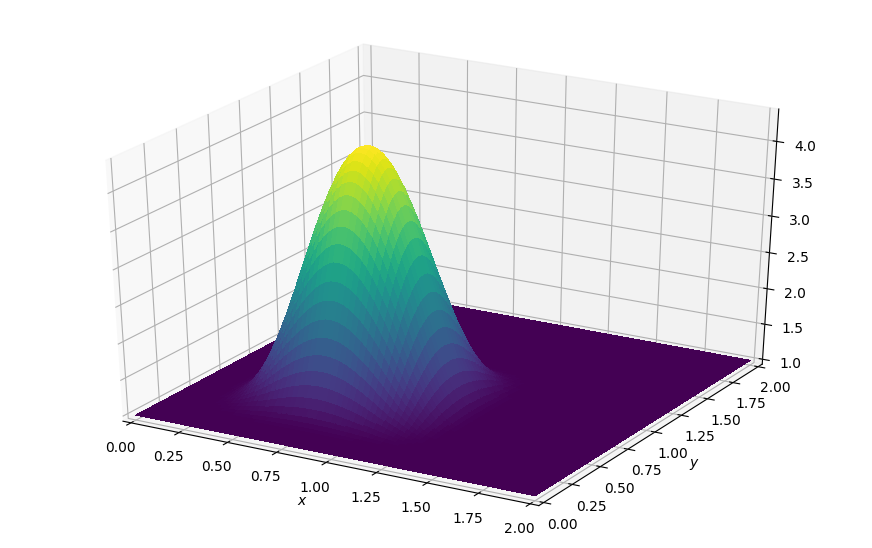

In [14]:
from examples.cfd import init_smooth, plot_field

nt = 100  # Number of timesteps
dt = 0.2 * 2. / 80  # Timestep size (sigma=0.2)
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(81, 81), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid)

# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
init_smooth(field=u.data[1], dx=grid.spacing[0], dy=grid.spacing[1])

plot_field(u.data[0])

Next, we wish to discretise our governing equation so that a functional `Operator` can be created from it. We begin by simply writing out the equation as a symbolic expression, while using shorthand expressions for the derivatives provided by the `Function` object. This will create a symbolic object of the dicretised equation.

Using the Devito shorthand notation, we can express the governing equations as:

In [15]:
eq = Eq(u.dt + c * u.dxl + c * u.dyl)
eq

Eq(Derivative(u(t, x, y), x) + Derivative(u(t, x, y), y) + Derivative(u(t, x, y), t), 0)

We now need to rearrange our equation so that the term $u(t+dt, x, y)$ is on the left-hand side, since it represents the next point in time for our state variable $u$. Devito provides a utility called `solve`, built on top of SymPy's `solve`, to rearrange our equation so that it represents a valid state update for $u$. Here, we use `solve` to create a valid stencil for our update to `u(t+dt, x, y)`:

In [16]:
stencil = solve(eq, u.forward)
update = Eq(u.forward, stencil)
update

Eq(u(t + dt, x, y), dt*(-Derivative(u(t, x, y), x) - Derivative(u(t, x, y), y) + u(t, x, y)/dt))

The right-hand side of the 'update' equation should be a stencil of the shape
<img src="figures/stencil_convection.png" style="width: 160px;"/>

Once we have created this 'update' expression, we can create a Devito `Operator`. This `Operator` will basically behave like a Python function that we can call to apply the created stencil over our associated data, as long as we provide all necessary unknowns. In this case we need to provide the number of timesteps to compute via the keyword `time` and the timestep size via `dt` (both have been defined above):

Operator `Kernel` ran in 0.01 s


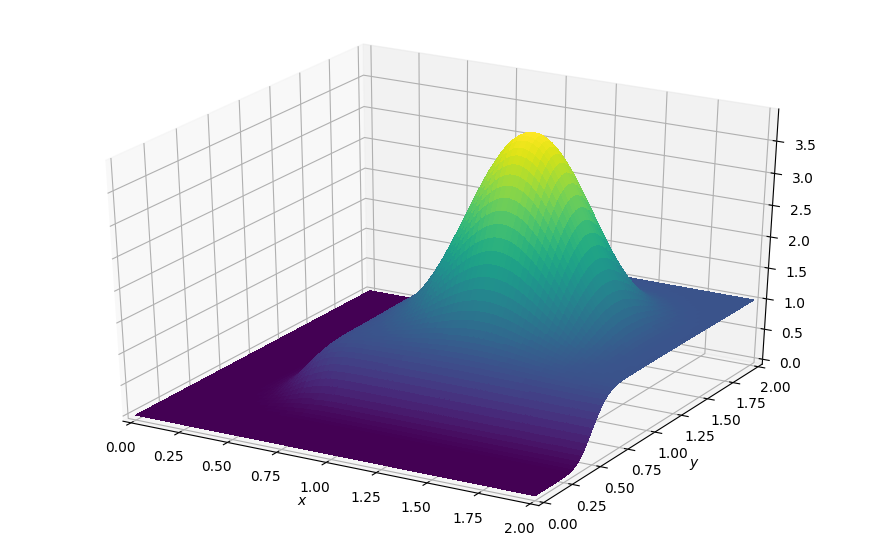

In [17]:
op = Operator(update, opt='noop')
op(time=nt+1, dt=dt)

plot_field(u.data[0])

Note that the real power of Devito is hidden within `Operator`, it will automatically generate and compile the optimized C code. We can look at this code (noting that this is not a requirement of executing it) via:

In [18]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "omp.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(const float dt, const float h_x, const float h_y, struct dataobj *restrict u_vec, const int time_M, const int time_m, const int x_M, const int x_m, const int y_M, const int y_m, const int nthreads, struct profiler * timers)
{
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;

  for (int time = time_m, t0 = (time)%(2), t1 = (time + 1)%(2)

## Second derivatives and high-order stencils

In the above example only a combination of first derivatives was present in the governing equation. However, second (or higher) order derivatives are often present in scientific problems of interest, notably any PDE modeling diffusion. To generate second order derivatives we must give the `devito.Function` object another piece of information: the desired discretisation of the stencil(s).

First, lets define a simple second derivative in `x`, for which we need to give $u$ a `space_order` of (at least) `2`. The shorthand for this second derivative is `u.dx2`. 

In [19]:
u = TimeFunction(name='u', grid=grid, space_order=2)
u.dx2

Derivative(u(t, x, y), (x, 2))

In [20]:
u.dx2.evaluate

-2.0*u(t, x, y)/h_x**2 + u(t, x - h_x, y)/h_x**2 + u(t, x + h_x, y)/h_x**2

We can increase the discretisation arbitrarily if we wish to specify higher order FD stencils:

In [21]:
u = TimeFunction(name='u', grid=grid, space_order=4)
u.dx2

Derivative(u(t, x, y), (x, 2))

In [22]:
u.dx2.evaluate

-2.5*u(t, x, y)/h_x**2 - 0.0833333333*u(t, x - 2*h_x, y)/h_x**2 + 1.33333333*u(t, x - h_x, y)/h_x**2 + 1.33333333*u(t, x + h_x, y)/h_x**2 - 0.0833333333*u(t, x + 2*h_x, y)/h_x**2

To implement the diffusion or wave equations, we must take the Laplacian $\nabla^2 u$, which is the sum of the second derivatives in all spatial dimensions. For this, Devito also provides a shorthand expression, which means we do not have to hard-code the problem dimension (2D or 3D) in the code. To change the problem dimension we can create another `Grid` object and use this to re-define our `Function`'s:

In [23]:
grid_3d = Grid(shape=(5, 6, 7), extent=(1., 1., 1.))

u = TimeFunction(name='u', grid=grid_3d, space_order=2)
u

u(t, x, y, z)

We can re-define our function `u` with a different `space_order` argument to change the discretisation order of the stencil expression created. For example, we can derive an expression of the 12th-order Laplacian $\nabla^2 u$:

In [24]:
u = TimeFunction(name='u', grid=grid_3d, space_order=12)
u.laplace

Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2))

The same expression could also have been generated explicitly via:

In [25]:
u.dx2 + u.dy2 + u.dz2

Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2))

## Derivatives of composite expressions

Derivatives of any arbitrary expression can easily be generated:

In [26]:
u = TimeFunction(name='u', grid=grid, space_order=2)
v = TimeFunction(name='v', grid=grid, space_order=2, time_order=2)

In [27]:
v.dt2 + u.laplace

Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + Derivative(v(t, x, y), (t, 2))

In [28]:
(v.dt2 + u.laplace).dx2

Derivative(Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + Derivative(v(t, x, y), (t, 2)), (x, 2))

Which can, depending on the chosen discretisation, lead to fairly complex stencils: 

In [29]:
(v.dt2 + u.laplace).dx2.evaluate

-2.0*(-2.0*u(t, x, y)/h_y**2 + u(t, x, y - h_y)/h_y**2 + u(t, x, y + h_y)/h_y**2 - 2.0*u(t, x, y)/h_x**2 + u(t, x - h_x, y)/h_x**2 + u(t, x + h_x, y)/h_x**2 - 2.0*v(t, x, y)/dt**2 + v(t - dt, x, y)/dt**2 + v(t + dt, x, y)/dt**2)/h_x**2 + (-2.0*u(t, x - h_x, y)/h_y**2 + u(t, x - h_x, y - h_y)/h_y**2 + u(t, x - h_x, y + h_y)/h_y**2 + u(t, x, y)/h_x**2 + u(t, x - 2*h_x, y)/h_x**2 - 2.0*u(t, x - h_x, y)/h_x**2 - 2.0*v(t, x - h_x, y)/dt**2 + v(t - dt, x - h_x, y)/dt**2 + v(t + dt, x - h_x, y)/dt**2)/h_x**2 + (-2.0*u(t, x + h_x, y)/h_y**2 + u(t, x + h_x, y - h_y)/h_y**2 + u(t, x + h_x, y + h_y)/h_y**2 + u(t, x, y)/h_x**2 - 2.0*u(t, x + h_x, y)/h_x**2 + u(t, x + 2*h_x, y)/h_x**2 - 2.0*v(t, x + h_x, y)/dt**2 + v(t - dt, x + h_x, y)/dt**2 + v(t + dt, x + h_x, y)/dt**2)/h_x**2